# **PDS Projekt -- Redukce dimenzionality a shluková analýza**


#### **Autor: Vojtěch Fiala \<xfiala61\>**

Tento Notebook popisuje druhou část projektu do PDS -- shlukování dat v poskytnutém datasetu. Bude rozdělen na 3 části a závěr.

- Předzpracování
- K-Means
- Hierarchické shlukování

Obdobně jako v předchozí části opět začneme importem potřebných knihoven a načtením datasetu.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import seaborn
from scipy import stats
from sklearn import datasets, decomposition, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cesta k datovemu souboru
INPUT_FILE_PATH = "./tls-pds-07-03-2024.parquet"

# Nacteni souboru
df = pandas.read_parquet(INPUT_FILE_PATH)

## Předzpracování

- Než začne jakákoliv analýza, je nutné data připravit do podoby, která umožní algoritmům fungovat. 
- Nejprve budou standardizovány číselné atributy. 
- V rámci předzpracování bude také nutné snížit dimenzionalitu dat, neboť obsahují příliš mnoho informací. Bude použita metoda PCA.
- Bude vytvořeno několik datasetů, kdy každý bude obsahovat jiné atributy, příp. jinak předzpracovaná data

<a id="datasets_explained"></a>
### Standardizace hodnot a odstranění nezajímavých dat

Na základě předchozí analýzy dat odstraníme sloupce s časem a nahradím je novým sloupcem *TIME*, který bude označovat dobu, po jakou tok trval. Výpovědní hodnota tohoto sloupce by měla být vyšší, než v případě dvou předchozích. 

Jelikož je v datasetu více než 1 milion řádků dat, za pomoci metody náhodného výběru zmenšíme velikost dataseti na desetinu původního za účelem zefektivnění prováděných úkonů.

Vytvořeno bude 5 odlišných datasetů, které se budou lišit v přítomnosti různých sloupců a filtrovaných dat:
- Ze všech datasetů se odstraní všechny *PPI_\** atributy a atribut *TLS_SNI* (ten zůstane pouze pro finální vyhodnocení - odstraněn bude až v sekci Redukce dimenzionality)
- Dataset 0 navíc odstraní i sloupec *TCP_FLAGS*. Z datasetu 0 budou odfiltrovány všechny toky mající méně než 5 záznamů
- Dataset 1 odstraní pouze *PPI_\** atributy. Dále odfiltruje toky mající méně než 5 záznamů celkem
- Dataset 2 odstraní *PPI_\** i sloupec *TCP_FLAGS*. Nic se dále neodfiltruje.
- Dataset 3 odstraní pouze *PPI_\** atributy. Nic se dále neodfiltruje.
- Dataset 4 odstraní *PPI_\**, *TCP_FLAGS* a *TIME*. Dále odfiltruje toky mající méně než 5 záznamů

Ze všech datasetů budou odstraněny extrémy za pomoci Z-score v případě, kdy je větší nebo rovno 3.

In [2]:
# Nejprve opet odstranim ze sloupcu  datove typy
for col in df.columns.tolist():
    col_names = col.split()
    if len(col_names) > 1:
        df = df.rename(columns={col:col_names[1]})


reduced_df_0 = df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_ a TCP Flags
reduced_df_1 = df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_
reduced_df_2 = df.copy(deep=True) # Odstranene sloupce PPI_ a TCP Flags 
reduced_df_3 = df.copy(deep=True) # Odstranene sloupce PPI_
reduced_df_4 = df.copy(deep=True) # Odstranene adresy < 5, odstranene sloupce PPI_ a TCP Flags a TIME

datasets = [reduced_df_0, reduced_df_1, reduced_df_2, reduced_df_3, reduced_df_4]

# Odstraneni sloupcu TIME_LAST a TIME_FIRST
try:
    # Urceni noveho sloupce, ktery nahradi tyto dva
    for i in range(len(datasets)):
        datasets[i]["TIME"] = (datasets[i]["TIME_LAST"] - datasets[i]["TIME_FIRST"]).astype('int64') // 1e9 # Delka toku v sekundach
        # Smazani sloupcu TIME_LAST a TIME_FIRST
        datasets[i] = datasets[i].drop(["TIME_LAST", "TIME_FIRST"], axis=1)
except:
    pass

print("Casy vlozeny")
tls_labels = []
try:    
    def remove_outliers(dataset):
        
        # Odstraneni "anomalii", tzn. toku, ktere maji mene nez 5 hodnot - vychazim z predchoziho notebooku
        cutoff_occurences = 5
        
        # Pocty toku k adresam
        val_counts = dataset["TLS_SNI"].value_counts()
        
        # Odfiltruj pocet vyskytu tam, kde je < 5 (tzn. nech jen ty, kde je > 4)
        val_counts = val_counts[val_counts >= cutoff_occurences]
        
        # Podle indexu vyfiltrovanych radku vyber jenom je (tzn. jejich indexy) -> pocet toku k adresam, ktere se objevily alespon 5x
        dataset = dataset[dataset["TLS_SNI"].isin(val_counts.index)]
        return dataset
        
    datasets[1] = remove_outliers(datasets[1])
    datasets[0] = remove_outliers(datasets[0])
    datasets[4] = remove_outliers(datasets[4])

except:
    pass


print("Filtrovani podle vyskytu adres hotovo")

try:
    # Odstraneni vsech PPI_ sloupcu a TCP_flagu
    datasets[0] = datasets[0].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS"], axis=1)

    # Odstraneni pouze PPI
    datasets[1] = datasets[1].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS"], axis=1)

    # Odstraneni pouze PPI
    datasets[3] = datasets[3].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS"], axis=1)

    # Odstraneni PPI a TCP_flagu
    datasets[2] = datasets[2].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS"], axis=1)

    # Odstraneni PPI a TCP_flagu a TIME
    datasets[4] = datasets[4].drop(["PPI_PKT_TIMES", "PPI_PKT_DIRECTIONS", "PPI_PKT_LENGTHS", "PPI_PKT_FLAGS", "TCP_FLAGS", "TIME"], axis=1)

    print("Sloupce odstraneny")
    
    for i in range(len(datasets)):
        # Z puvodniho datasetu vezmu nahodne jen desetinu hodnot - jinak trvaji operace moc dlouho
        sample_size = int(datasets[i].shape[0] / 10)
        datasets[i] = datasets[i].sample(n=sample_size, random_state=42)

        # Odstraneni TLS_SNI, ktere jakozto ciste string hodnoty nebudou fungovat s PCA
        tls_labels.append(datasets[i]["TLS_SNI"])
        datasets[i] = datasets[i].drop(["TLS_SNI"], axis=1)

        print("Odstranovani outlieru z datasetu", i)

        # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
        # Odstraneni outlieru - pro kazdy sloupec musi byt hodnota 3x smerodatna odchylka od prumeru
        datasets[i] = datasets[i][(numpy.abs(stats.zscore(datasets[i])) < 3).all(axis=1)]
        
except Exception as error:
    print(error)

Casy vlozeny
Filtrovani podle vyskytu adres hotovo
Sloupce odstraneny
Odstranovani outlieru z datasetu 0
Odstranovani outlieru z datasetu 1
Odstranovani outlieru z datasetu 2
Odstranovani outlieru z datasetu 3
Odstranovani outlieru z datasetu 4


In [3]:
# https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

standardize = 1

# Funkce pro standardizace sloupce
def standardize_column(column):
    # Prevod na format, se kterym StandardScaler() umi pracovat
    column_2d = column.values.reshape(-1, 1)

    # Priprava scaling objektu
    scaler = preprocessing.RobustScaler().fit(column_2d)

    # Standardizovany sloupec
    norm = scaler.transform(column_2d)

    # Vytvorim znovu pandas objekt
    column_normalized_series = pandas.Series(norm.flatten(), index=column.index)

    return column_normalized_series

if (standardize):
    for i in range(len(datasets)):
        # Standardizace mnozstvi paketu klient->server
        datasets[i]["PACKETS"] = standardize_column(datasets[i]["PACKETS"])

        # Standardizace mnozstvi paketu server->klient
        datasets[i]["PACKETS_REV"] = standardize_column(datasets[i]["PACKETS_REV"])

        # Standardizace mnozstvi bytu klient->server
        datasets[i]["BYTES"] = standardize_column(datasets[i]["BYTES"])
    
        datasets[i]["BYTES_REV"] = standardize_column(datasets[i]["BYTES_REV"])

    # Standardizace casu
    datasets[0]["TIME"] = standardize_column(datasets[0]["TIME"])
    datasets[1]["TIME"] = standardize_column(datasets[1]["TIME"])
    datasets[2]["TIME"] = standardize_column(datasets[2]["TIME"])
    datasets[3]["TIME"] = standardize_column(datasets[3]["TIME"])


### Redukce dimenzionality -- PCA

Buňka níže popisuje aplikaci PCA. Z původních 6 sloupců vzniknou jen 2. 

Redukce na pouze 2 sloupce byla zvolena ze dvou důvodů: 
- snadnější vizualizace výsledku
- redukce na 2 sloupce má o trošku lepší výsledky než na 3

In [4]:
import copy
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py

# Redukce poctu dimenzi na 2 -- v pripade 3 jsou o trosku horsi vysledky (ale podobne) -- experimentalne overeno
datasets_save = []
df_pcas  = []
for i in range(len(datasets)):
    datasets_save.append(copy.deepcopy(datasets[i]))
    pca = decomposition.PCA(n_components=2)
    pca = pca.fit(datasets[i])
    df_pca = pca.transform(datasets[i])
    df_pcas.append(df_pca)
datasets = df_pcas

## K-Means algoritmus
První shlukování, které se v Notebooku provede, bude s využitím algoritmu K-Means. 

### Počet clusterů

Prvním krokem K-means shlukování bude výpočet optimálního počtu clusterů.


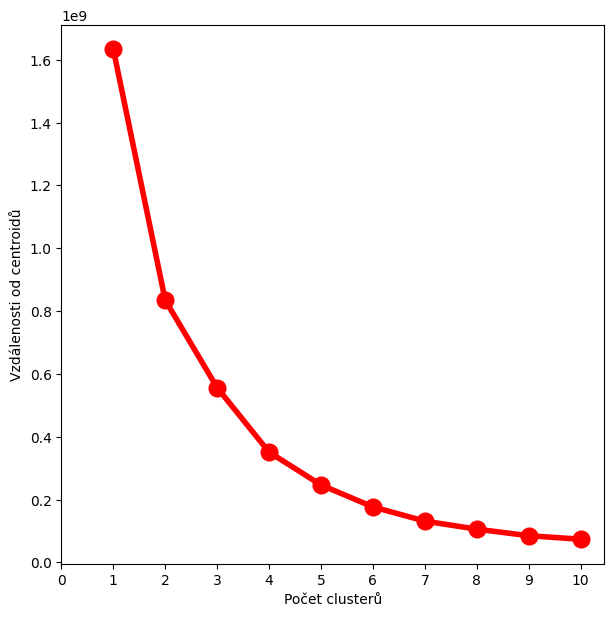

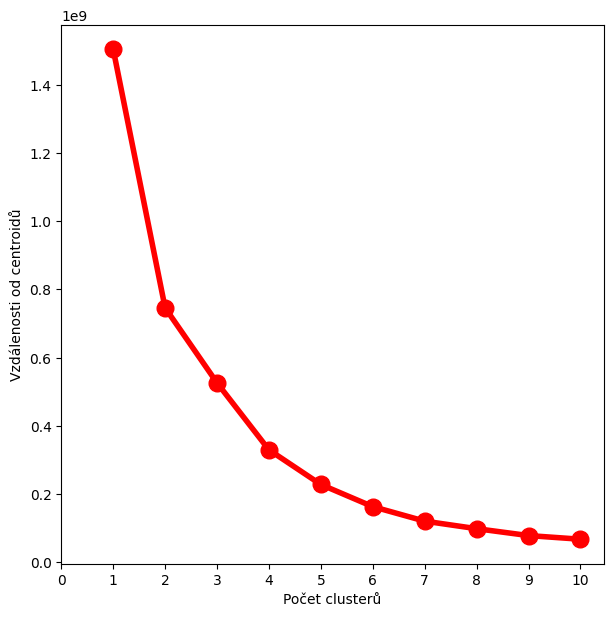

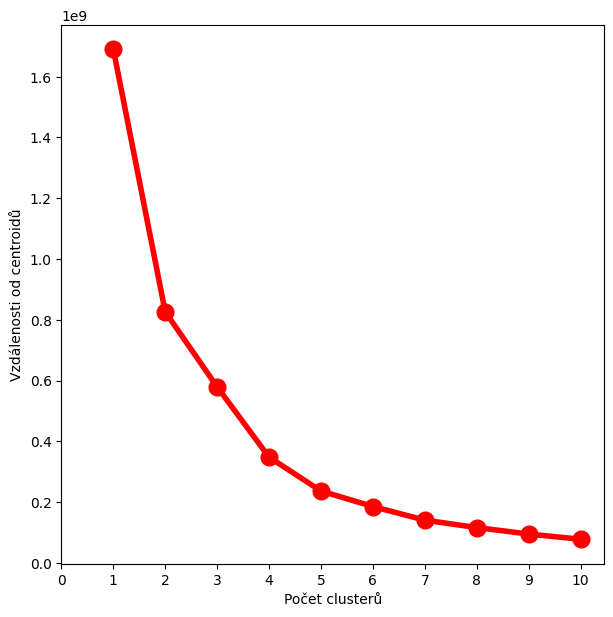

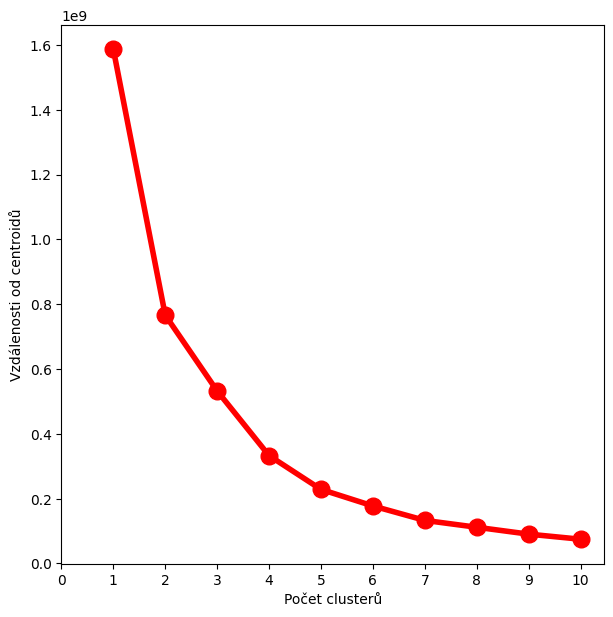

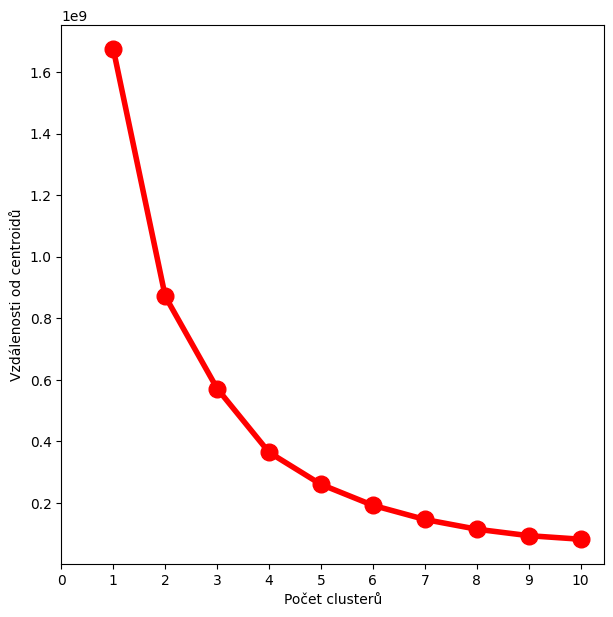

In [5]:
# https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
# Vypocet K-means pro pocet clusteru 1-11.
# Podle vysledneho grafu se urci bod (pocet clusteru), za kterym uz se hodnoty prilis nezlepsuji
for i in range(len(datasets)):
    WCSS = []
    for j in range(1,11):
        model = KMeans(n_clusters = j, init = 'k-means++', n_init=5, max_iter=100, random_state=42)
        model.fit(datasets[i])
        WCSS.append(model.inertia_)
    fig = plt.figure(figsize = (7,7))
    plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
    plt.xticks(numpy.arange(11))
    plt.xlabel("Počet clusterů")
    plt.ylabel("Vzdálenosti od centroidů")
    plt.show()

#### Optimální množství clusterů
- Množství clusterů bylo zvoleno na základě tzv. [*elbow*](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) metody
- Z grafů výše vyplývá, že optimální množství clusterů bude 5 pro všechny datasety. Poté už zisky graficky neospraveddlňují overfitting.

### Výpočet K-means a vyhodnocení úspěšnosti

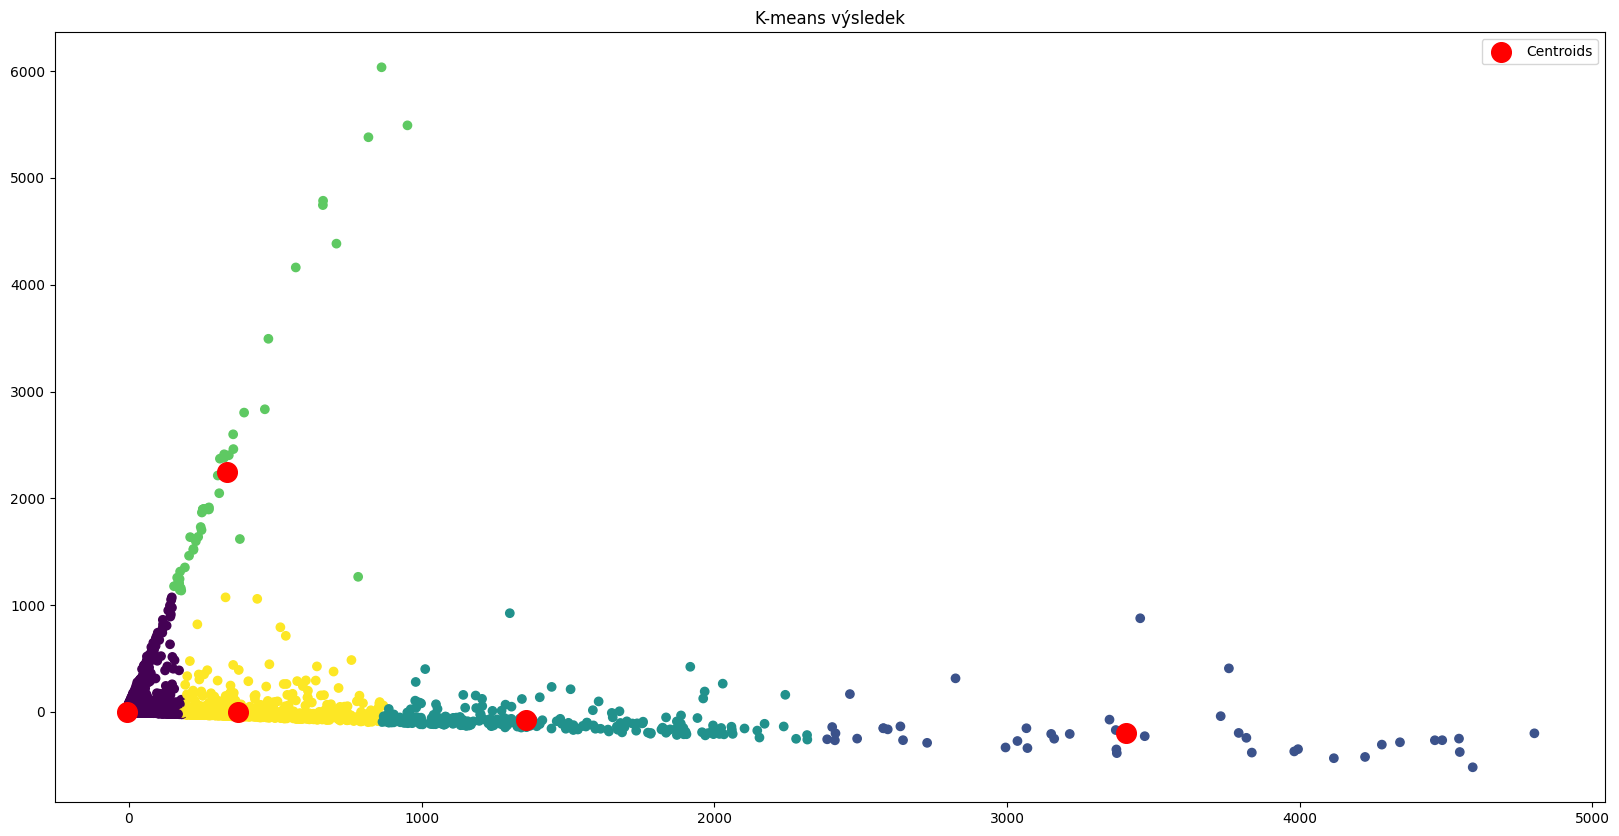

Davies-Bouldin index pro dataset 0: 0.4829368899476497


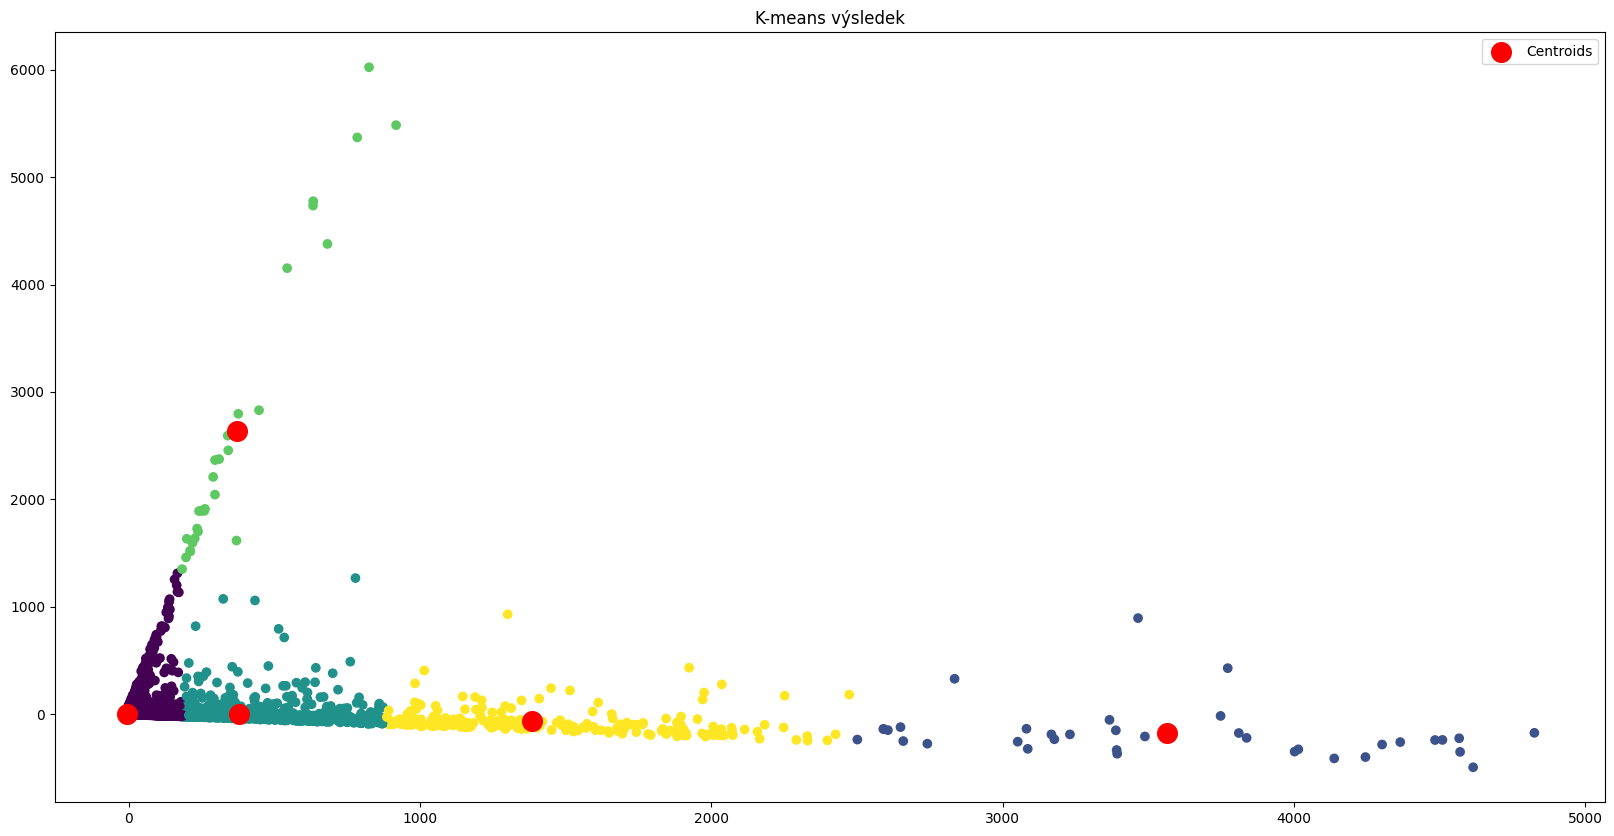

Davies-Bouldin index pro dataset 1: 0.4856821367216601


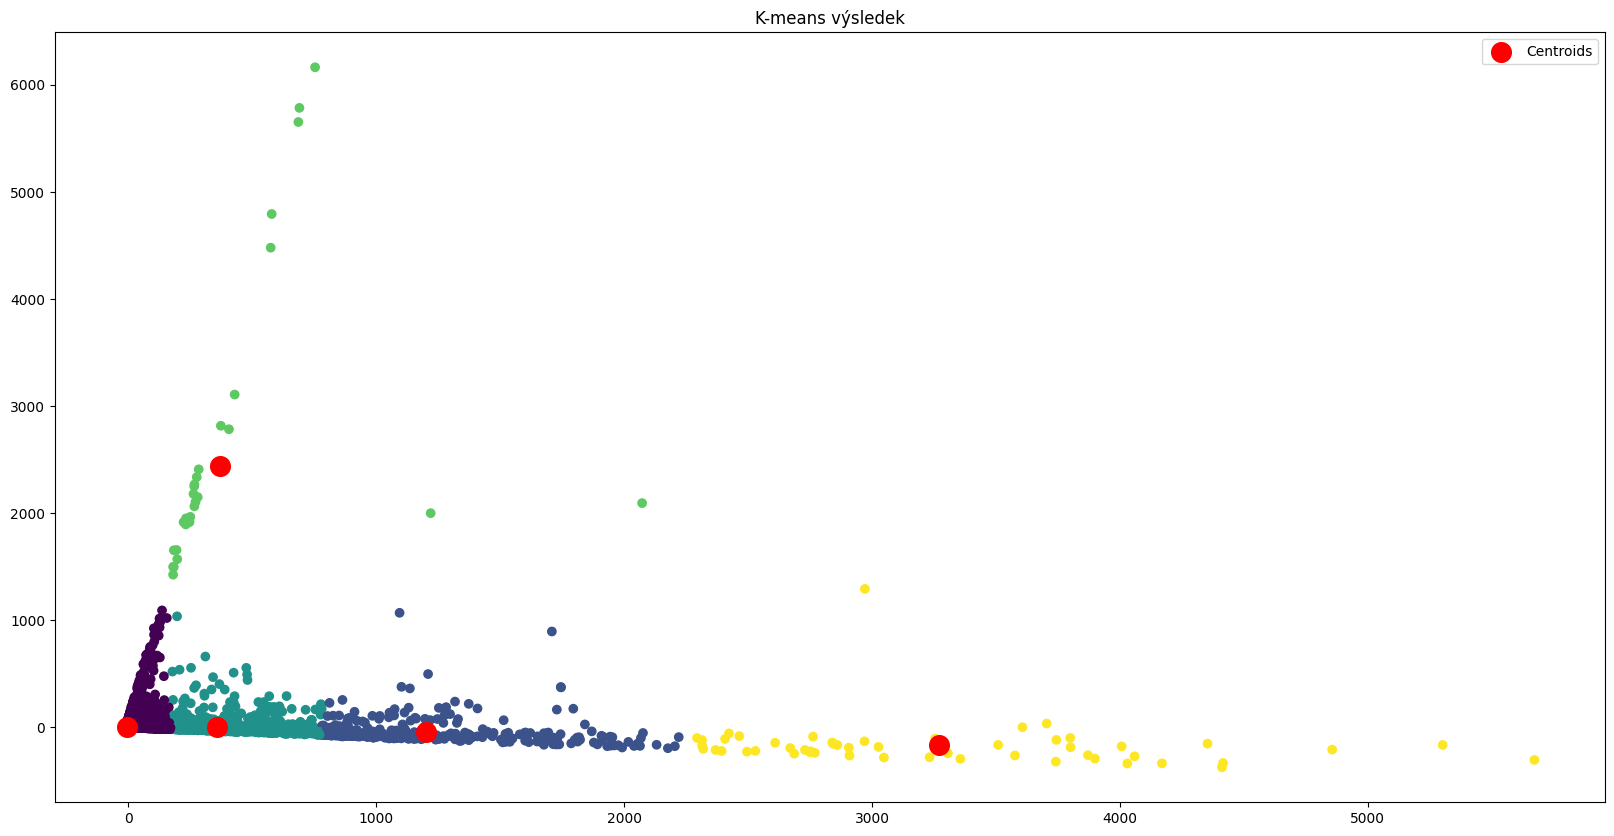

Davies-Bouldin index pro dataset 2: 0.4825443833166312


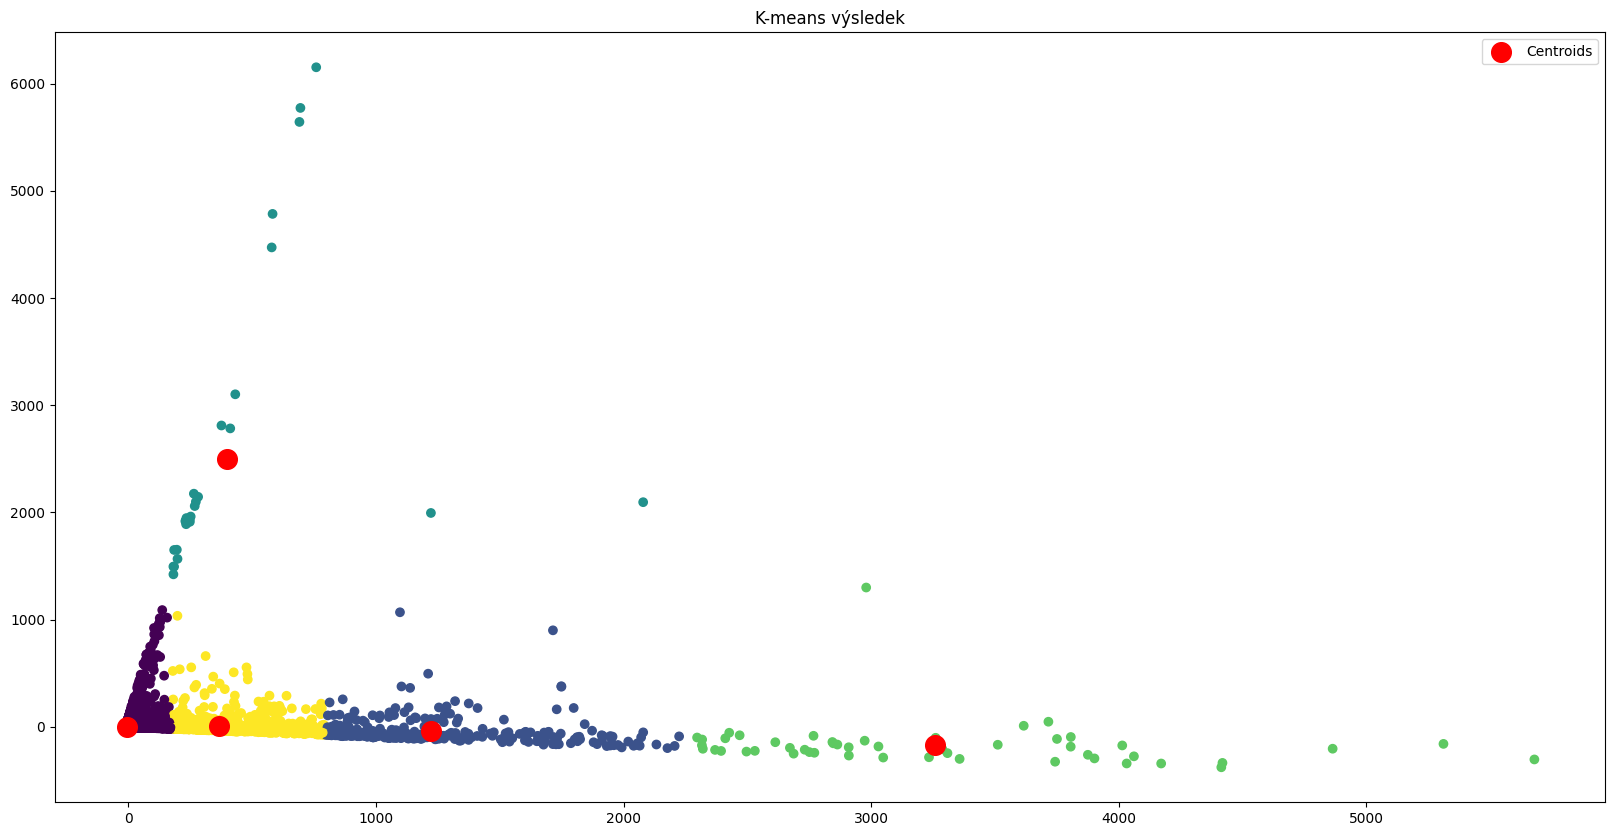

Davies-Bouldin index pro dataset 3: 0.497800069948803


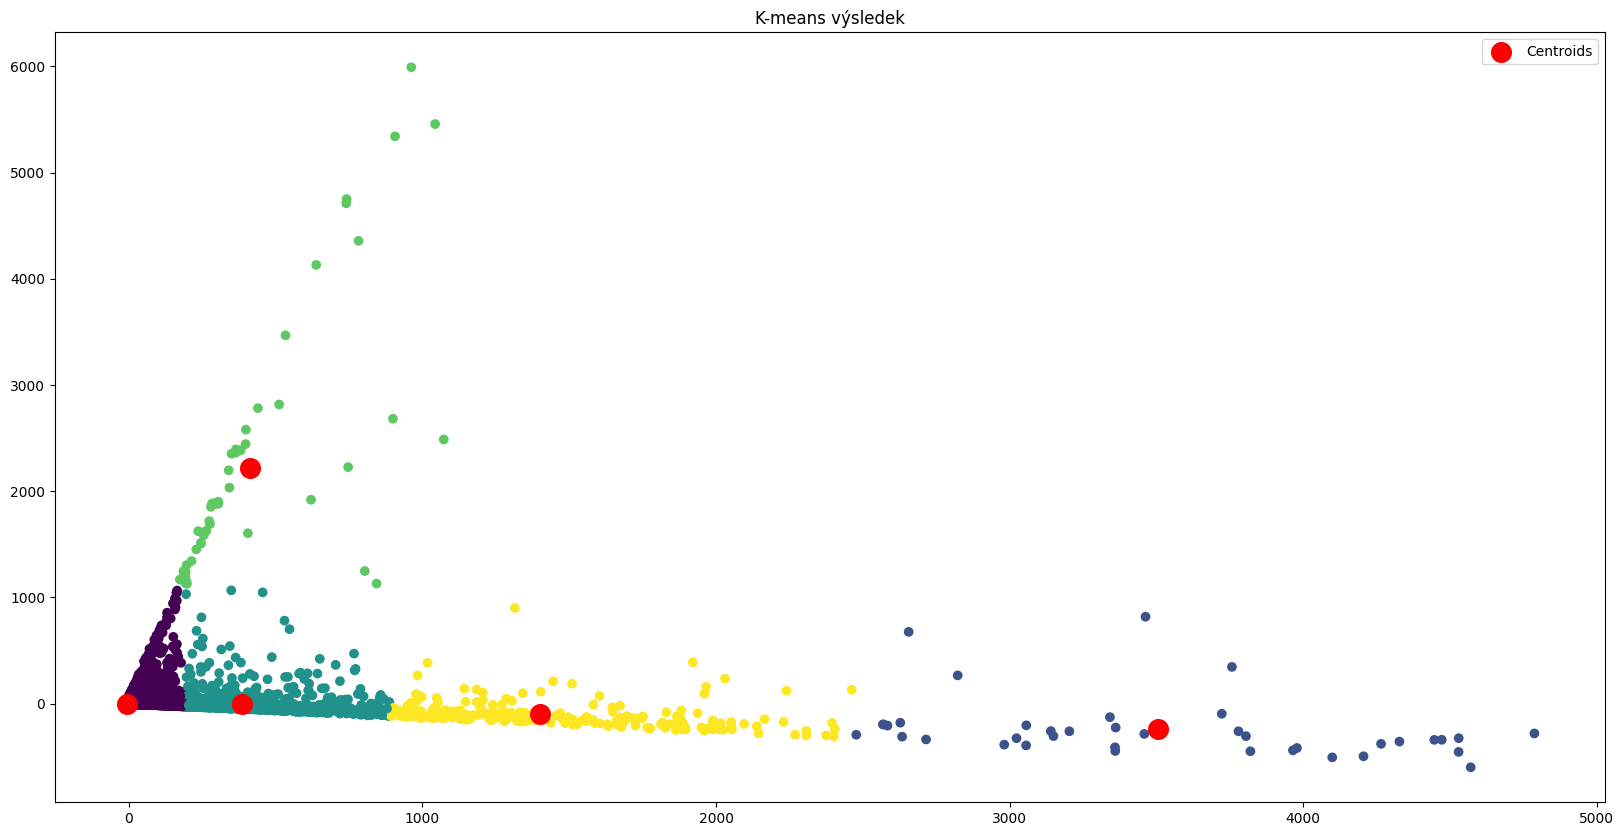

Davies-Bouldin index pro dataset 4: 0.4856674860670928


In [6]:
from sklearn.metrics import davies_bouldin_score

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
for i in range(len(datasets)):
    kmeans = KMeans(init="k-means++", n_init=5, n_clusters=5, max_iter=100, random_state=42)
    kmeans.fit(datasets[i])
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    plt.figure(figsize = (20,10))
    plt.scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, label='Centroids')
    plt.title('K-means výsledek')
    plt.legend()
    plt.show()
    
    # Prirazeni 
    datasets_save[i]["CLUSTER"] = labels
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
    # Cim blize je cislo k 0, tim kvalitnejsi clustery jsou
    dbi = davies_bouldin_score(datasets[i], kmeans.labels_)
    
    print("Davies-Bouldin index pro dataset " + str(i) + ":", dbi)

#### Výsledek K-means
- Vizualizace zobrazuje rozložení vzniklých 5 clusterů v prostoru pro každý dataset.
- Jako metrika úspěšnosti se použil Davies-Bouldin index. Čím blíže je index k 0, tím kvalitnější výsledky jsou. Hodnota *0.483* se ovšem za kvalitní označit nedá, ačkoliv je ze všech získaných nejlepší
- Nejlepší koeficienty (*0.483*) byly získány pro dataset 0 a dataset 2 (detailnější popis viz začátek této [sekce](#datasets_explained)). Rozdíl oproti ostatním datasetům byl však velmi malý.
- Experimentálně byly odzkoušeny různé nastavení K-means, společně s používáním kombinací konkrétních sloupců. Žádný z výsledků ovšem  nevypadá tak, jak by K-means vypadat měl.
- Důvod nízké kvality clusterování mohou být i data samotná -- mohou v nich figurovat nezachycené anomálie, nebo mohlo dojít i k jiným, neobjeveným problémům.

### Vyhodnocení shluků
Další výsledky vychází již pouze z nejlepšího nastavení, tzn. pro dataset 0.
Pro jednotlivé nalezené shluky bude prozkoumáno 10 nejčastějších služeb a bude hledána podobnost mezi nimi.

#### Množství hodnot v clusterech

CLUSTER
0    124857
4      1093
2       243
3        54
1        43
Name: count, dtype: int64


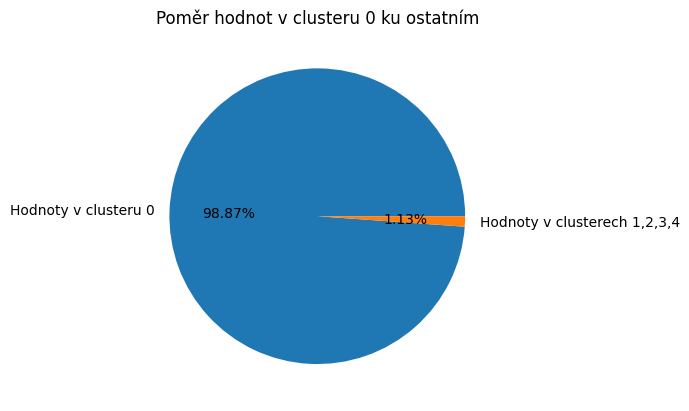

In [7]:
# Navrat puvodnich TLS_SNI hodnot pro dataset 0
df = datasets_save[0]
df["TLS_SNI"] = tls_labels[0]

print(df["CLUSTER"].value_counts())

n_of_zero_cl = df["CLUSTER"].value_counts().nlargest(1).sum()
rest = df["CLUSTER"].value_counts().sum() - n_of_zero_cl

fig, ax = plt.subplots()
ax.pie([n_of_zero_cl, rest], labels=["Hodnoty v clusteru 0", "Hodnoty v clusterech 1,2,3,4"], autopct='%1.2f%%');
ax.set_title("Poměr hodnot v clusteru 0 ku ostatním");

- Většina hodnot (*98.87%*) je v clusteru 0
- Z důvodu takto jednostranného rozdělení se výsledky K-means nedají označit za kvalitní.

Dále se zaměříme na hodnoty v jednotlivých clusterech -- co mají společné.

In [8]:
cluster_counts_tls = df.groupby("CLUSTER")["TLS_SNI"].value_counts()
cluster_counts_tls.groupby("CLUSTER").nlargest(10)

CLUSTER  CLUSTER  TLS_SNI                                 
0        0        www.google.com                              7258
                  dns.google                                  3042
                  fonts.gstatic.com                           2871
                  doh.opendns.com                             2870
                  play.googleapis.com                         2430
                  googleads.g.doubleclick.net                 2262
                  safebrowsing.googleapis.com                 2242
                  www.youtube.com                             2166
                  www.googleapis.com                          2105
                  play.google.com                             2095
1        1        mail.google.com                                3
                  www.google.com                                 2
                  cz-bks400-prod03-live.solocoo.tv               2
                  cz-bks400-prod15-live.solocoo.tv               2
   

- Z výčtu jednotlivých názvů serverů je patrné, že stejné adresy se vyskytují ve více clusterech. 
- Jak zmiňuje zadání, je možné, že služby jako www.youtube.com mají více různých toků (metadata, video...)
- To by odovídalo tomu, že jak lze vidět v clusteru 1, jsou v něm primárně videoslužby, ze kterých se stahovala data.
- Výsledků v daném clusteru je však natolik málo, že není možné jednoznačně říct, že se nejedná o chybu.

## Hierarchické shlukování
Tato sekce je zaměřena na druhou metodu clusterování, která bude v notebooku popsána. Jedná se o hierarchické clusterování. Prováděno bude se stejnými datasety, se kterými pracoval i K-Means algoritmus.

Jelikož je proces velmi náročný, je nutné ještě dále snížit množství hodnot v datasetu (opět /10) a znovu provést PCA.

In [9]:
import copy
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py

# Redukce poctu dimenzi na 2 -- v pripade 3 jsou o trosku horsi vysledky (ale podobne) -- experimentalne overeno
datasets = datasets_save
shorter_tls_labels = []

for i in range(len(datasets)):
    datasets[i]["TLS_SNI"] = tls_labels[i]
    # Z uz zkraceneho datasetu vezmu nahodne jen desetinu hodnot - jinak trvaji operace moc dlouho
    sample_size = int(datasets[i].shape[0] / 10)
    datasets[i] = datasets[i].sample(n=sample_size, random_state=42)

    # Odstraneni TLS_SNI, ktere jakozto ciste string hodnoty nebudou fungovat s PCA
    shorter_tls_labels.append(datasets[i]["TLS_SNI"])
    datasets[i] = datasets[i].drop(["TLS_SNI"], axis=1)

df_pcas  = []
datasets_save = []
for i in range(len(datasets)):
    datasets_save.append(copy.deepcopy(datasets[i]))
    pca = decomposition.PCA(n_components=2)
    pca = pca.fit(datasets[i])
    df_pca = pca.transform(datasets[i])
    df_pcas.append(df_pca)
datasets = df_pcas

Davies-Bouldin index pro dataset 0 a metodu ward: 0.3813242890769903
Davies-Bouldin index pro dataset 0 a metodu complete: 0.36858052282536696
Davies-Bouldin index pro dataset 0 a metodu average: 0.11083087096698717
Davies-Bouldin index pro dataset 0 a metodu single: 0.06967245677105056


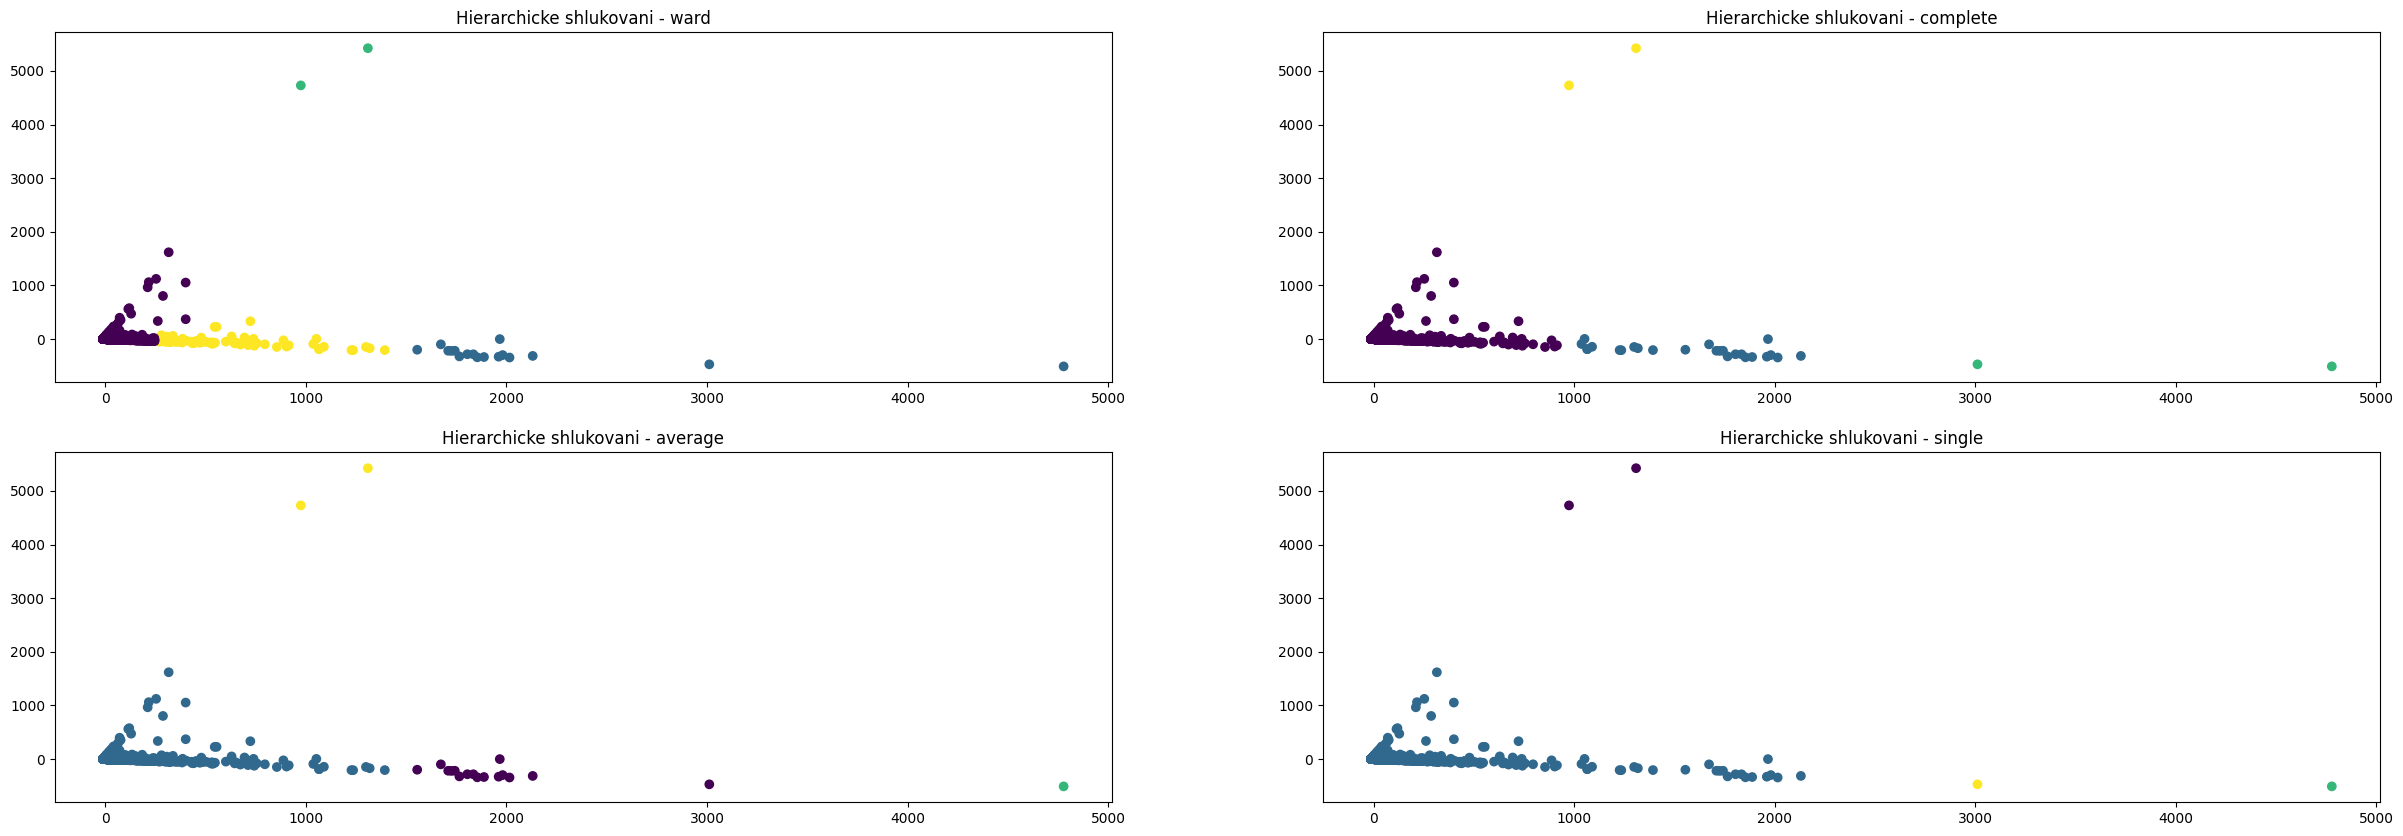

Davies-Bouldin index pro dataset 1 a metodu ward: 0.3362090520146717
Davies-Bouldin index pro dataset 1 a metodu complete: 0.3198719163980714
Davies-Bouldin index pro dataset 1 a metodu average: 0.18295675470449696
Davies-Bouldin index pro dataset 1 a metodu single: 0.09762957527911668


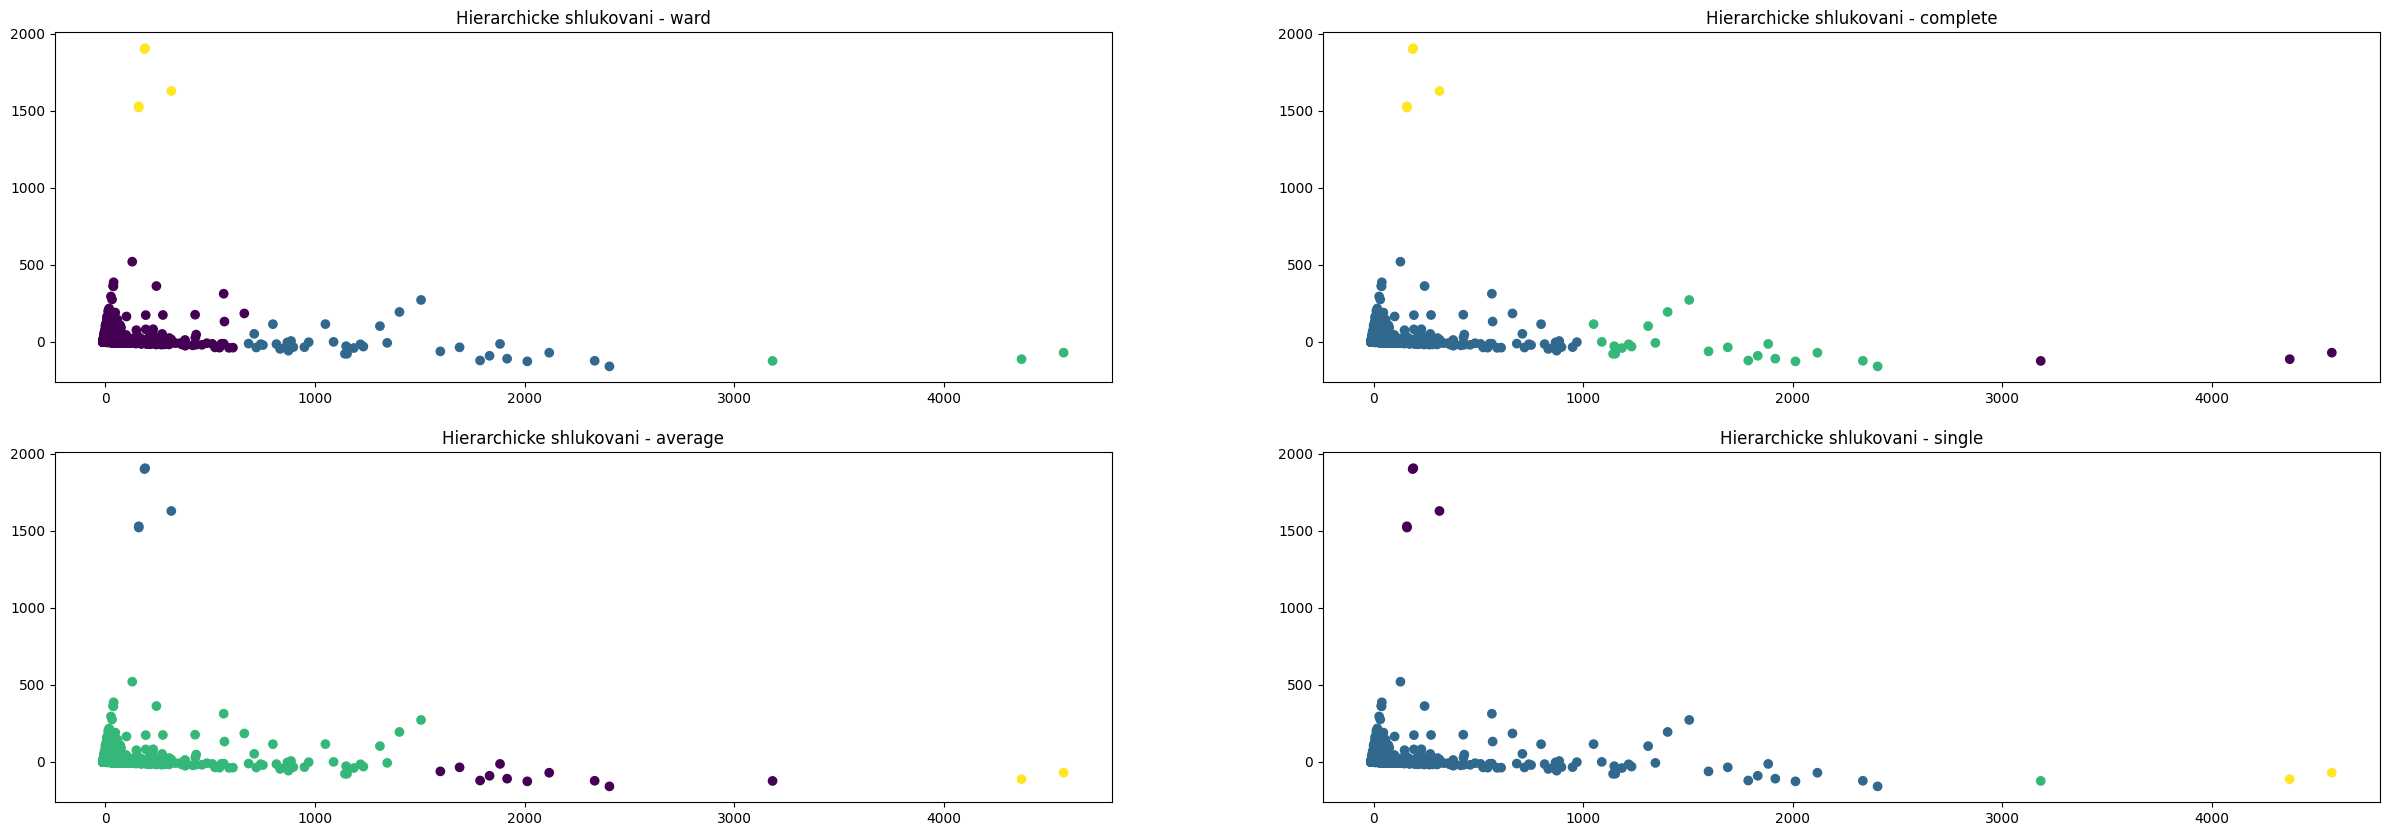

Davies-Bouldin index pro dataset 2 a metodu ward: 0.312042990447883
Davies-Bouldin index pro dataset 2 a metodu complete: 0.3661051295359415
Davies-Bouldin index pro dataset 2 a metodu average: 0.3579175414138858
Davies-Bouldin index pro dataset 2 a metodu single: 0.18868997227538958


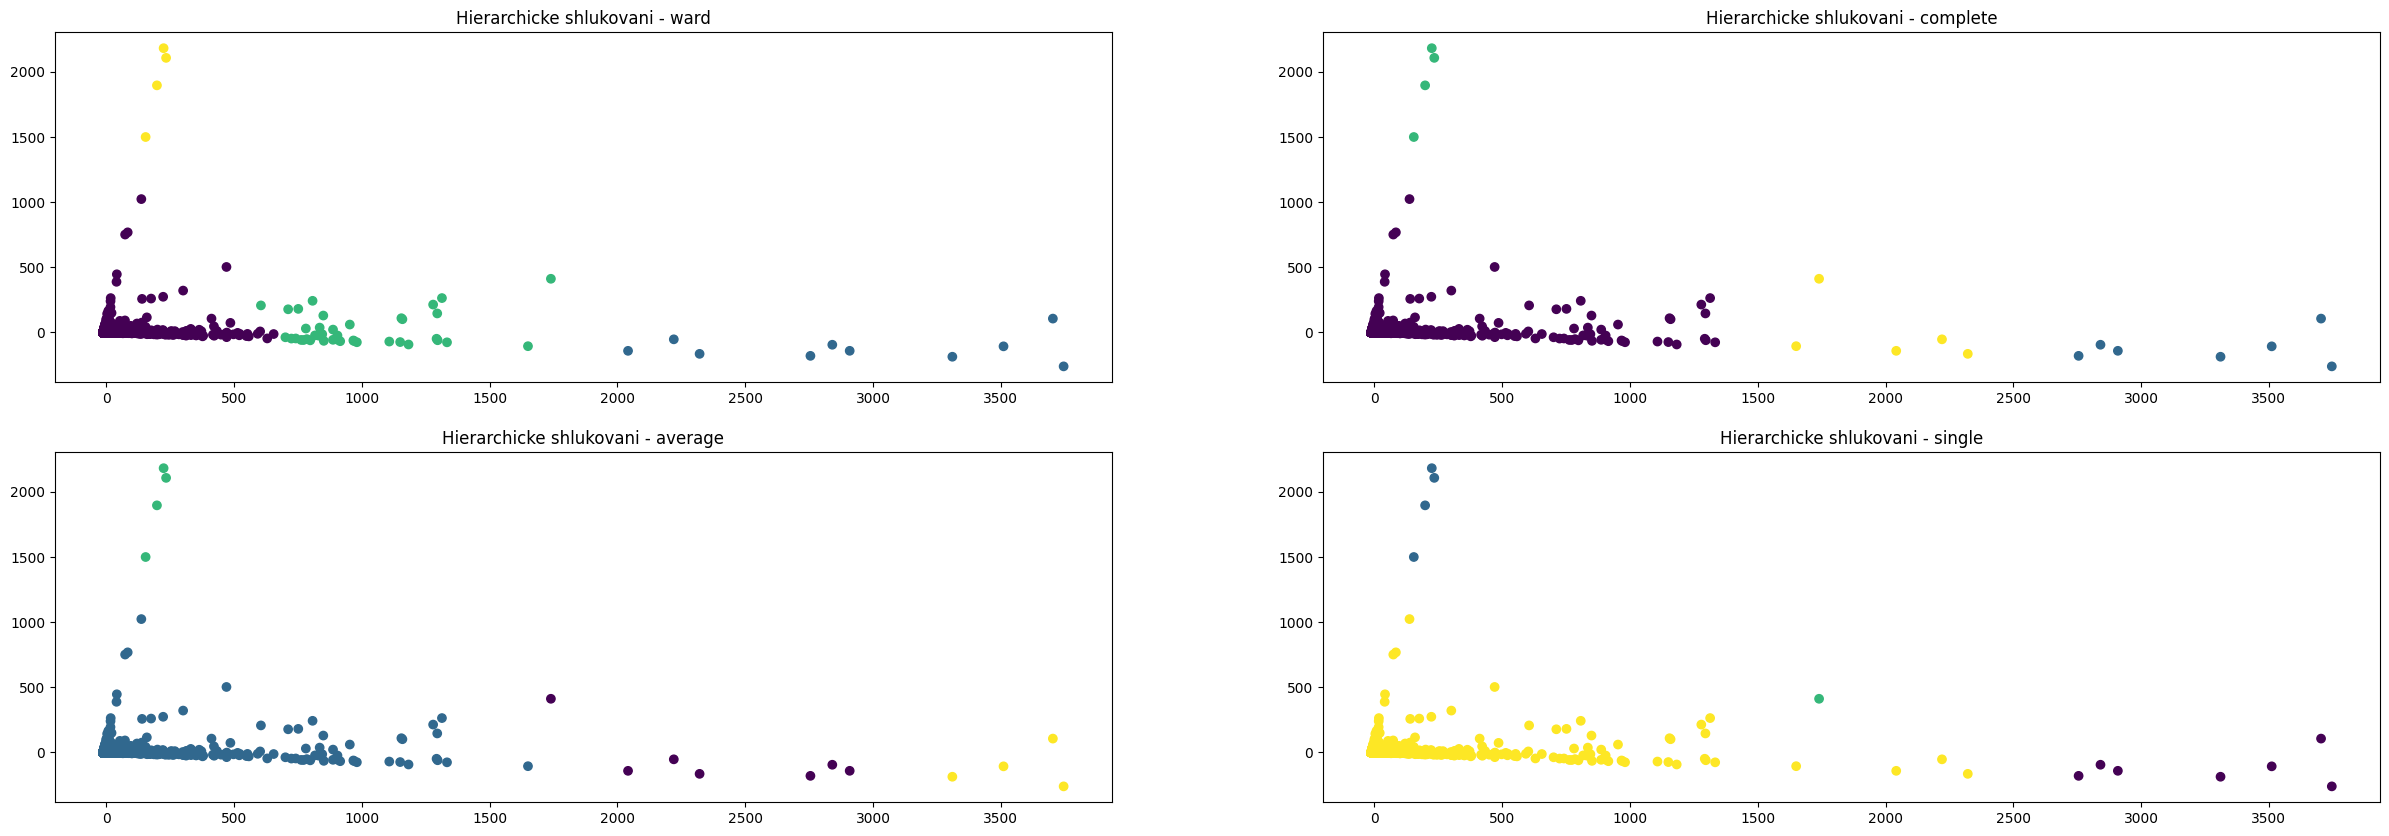

Davies-Bouldin index pro dataset 3 a metodu ward: 0.6483151105419205
Davies-Bouldin index pro dataset 3 a metodu complete: 0.36827225627713617
Davies-Bouldin index pro dataset 3 a metodu average: 0.3834725366951457
Davies-Bouldin index pro dataset 3 a metodu single: 0.0700971050125303


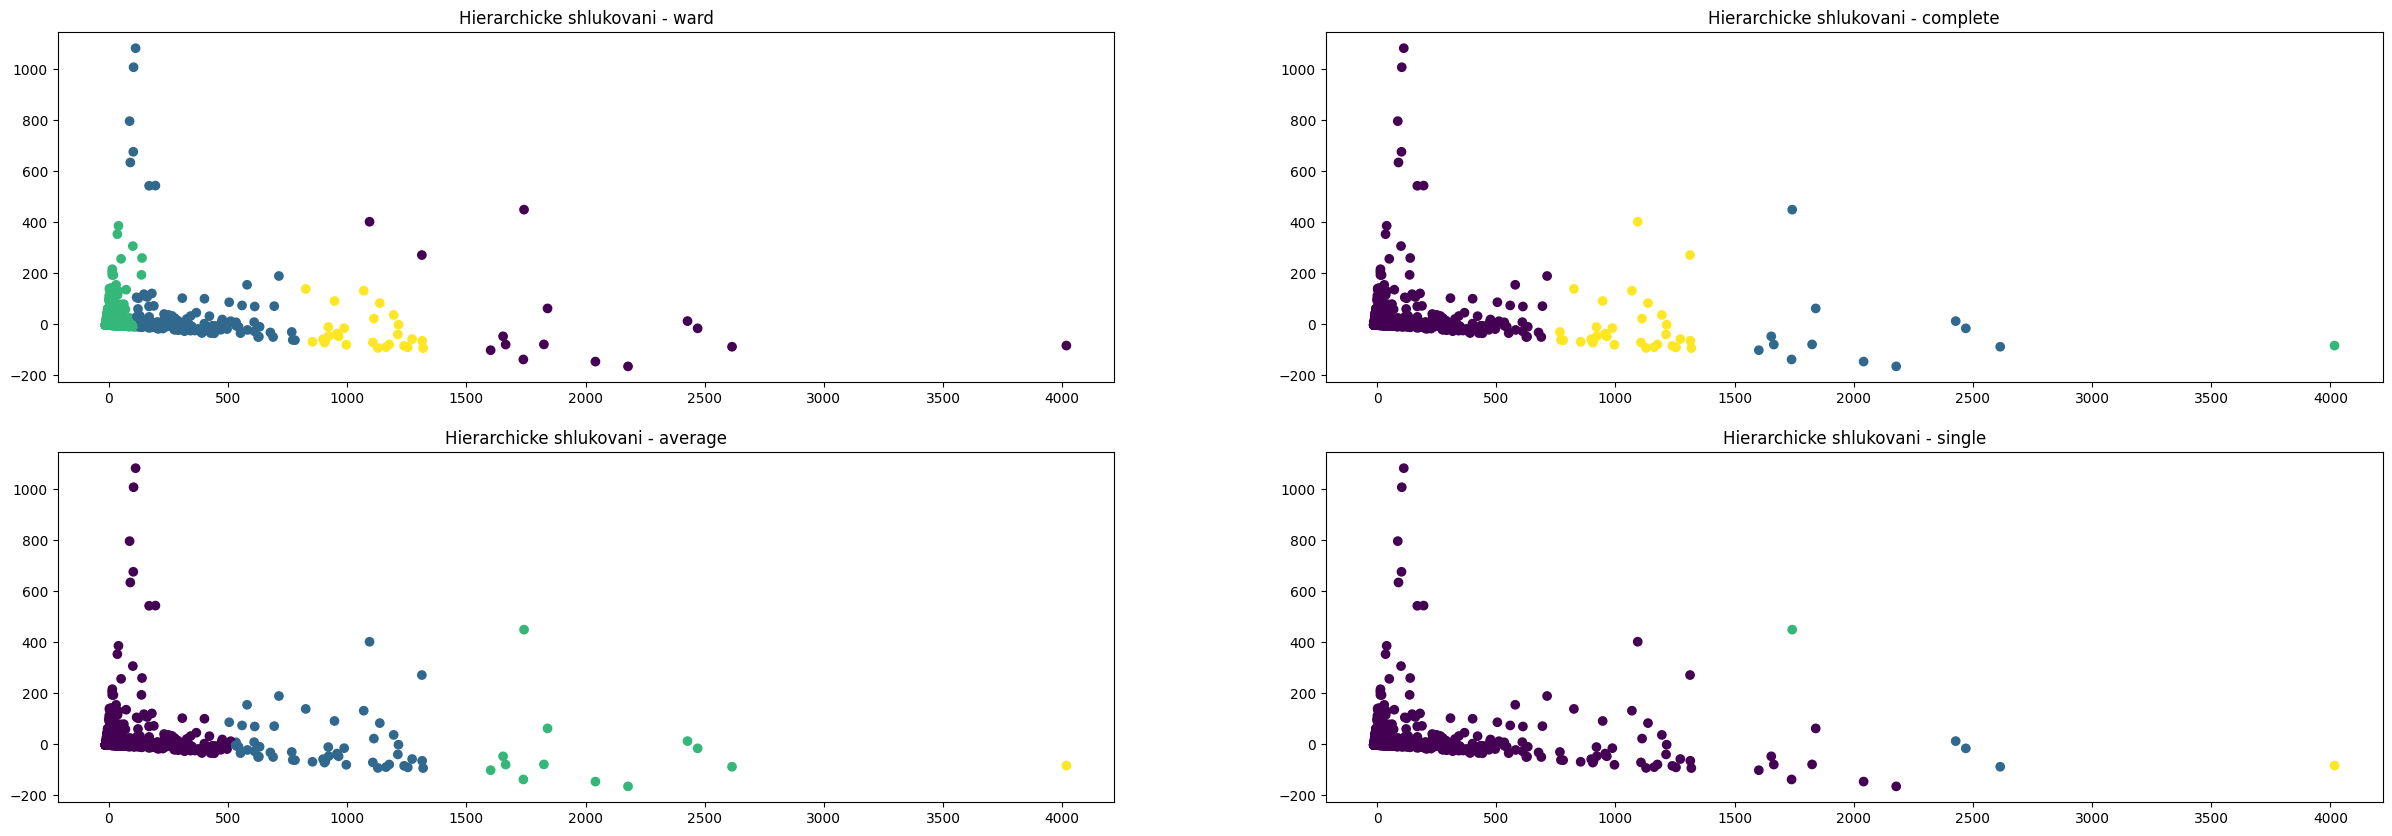

Davies-Bouldin index pro dataset 4 a metodu ward: 0.5605429087249906
Davies-Bouldin index pro dataset 4 a metodu complete: 0.24617666204269678
Davies-Bouldin index pro dataset 4 a metodu average: 0.24617666204269678
Davies-Bouldin index pro dataset 4 a metodu single: 0.15456698563585017


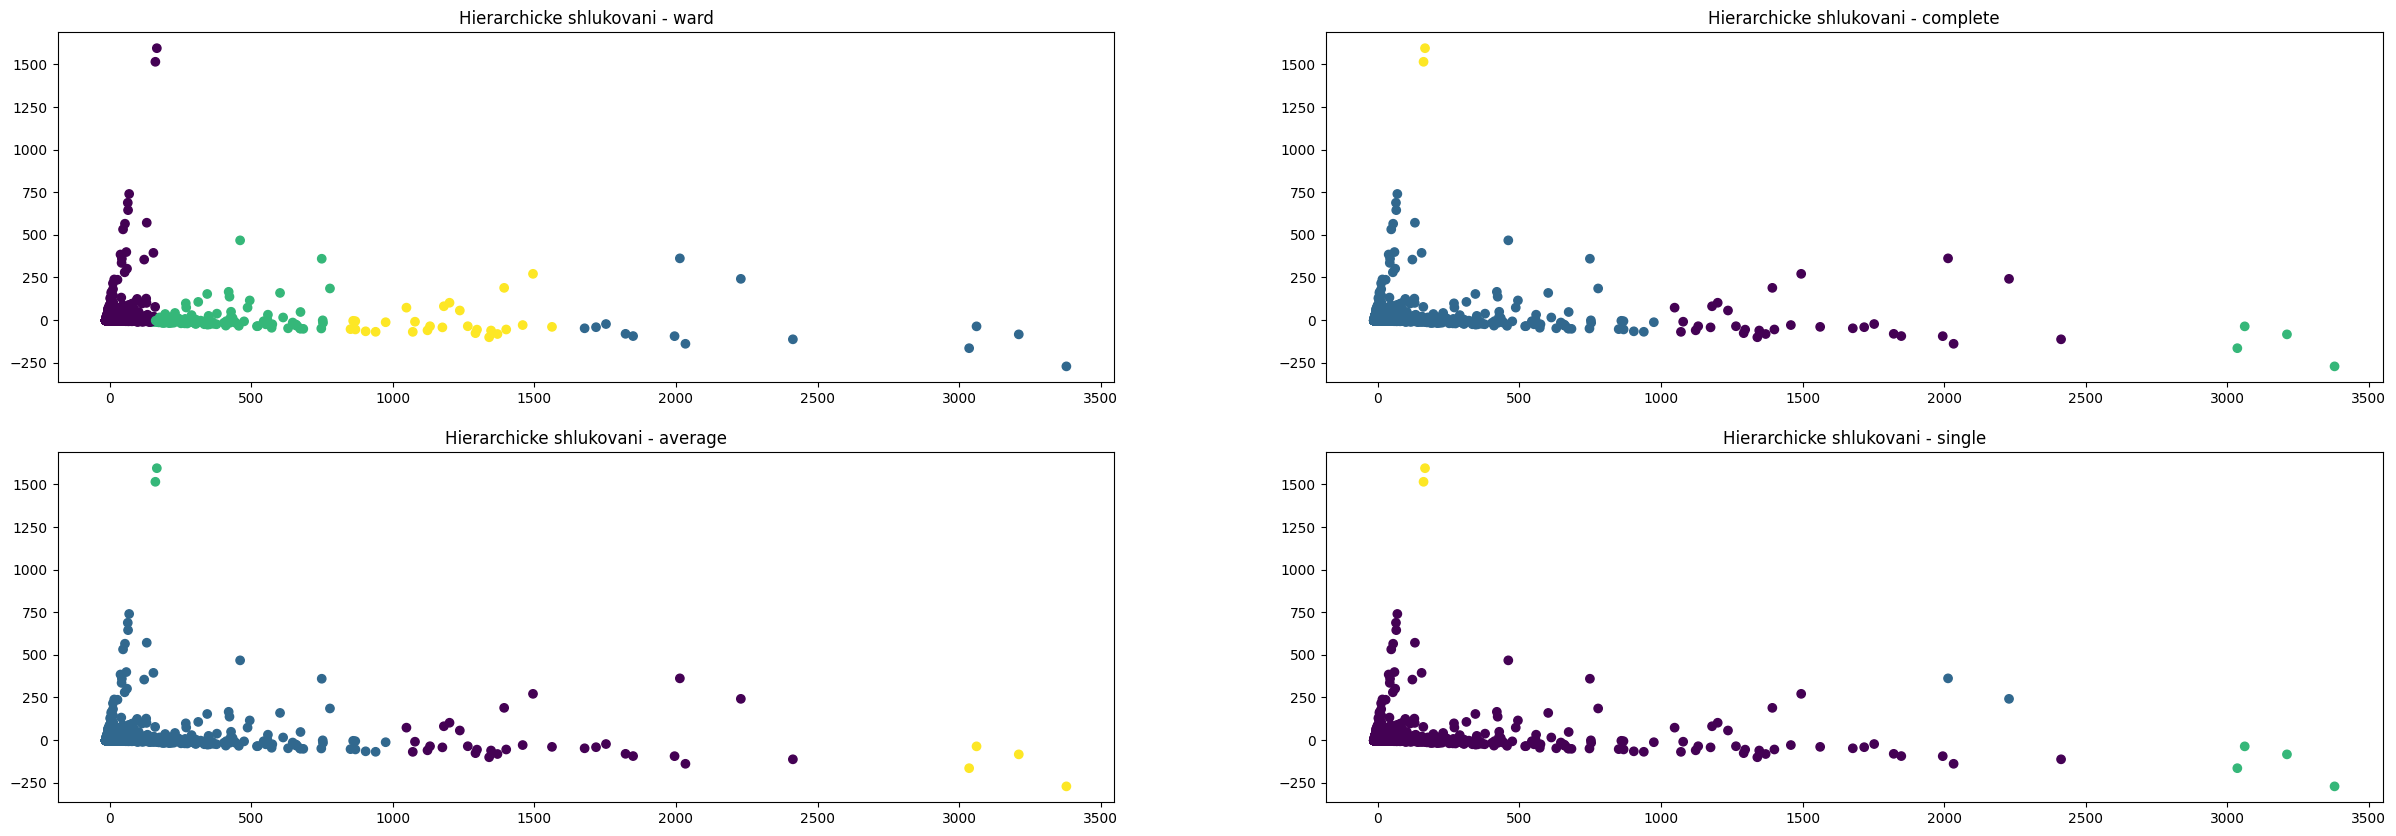

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
# Pro kazdy dataset provedu 4 ruzne zpusoby hierarchickeho shlukovani, vzdy s 4 clustery
for i in range(len(datasets)):
    
    fig, ax = plt.subplots(2, 2, figsize = (30,10))

    # Odzkousim tyto 4 parametry
    methods = ["ward", "complete", "average", "single"]
    method_index = 0
    best_labels_measurement = 1
    best_labels = None
    for j in range(2):
        for k in range(2):
            method = methods[method_index]
            hierarchical_clustering = AgglomerativeClustering(n_clusters=4, linkage=method)
            hierarchical_clustering.fit(datasets[i])
        
            labels = hierarchical_clustering.labels_
        
            ax[j][k].scatter(datasets[i][:, 0], datasets[i][:, 1], c=labels)
            ax[j][k].set_title("Hierarchicke shlukovani - " + method)
            method_index += 1
            
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
            # Cim blize je cislo k 0, tim kvalitnejsi clustery jsou
            dbi = davies_bouldin_score(datasets[i], labels)

            if dbi < best_labels_measurement and method != "single" and method != "average" and method != "complete":
                best_labels_measurement = dbi
                best_labels = labels
            
            print("Davies-Bouldin index pro dataset " + str(i) + " a metodu " + method + ":", dbi)

    # Prirazeni podle nejlepsi metody
    datasets_save[i]["CLUSTER"] = best_labels
        
    plt.show()


### Počet clusterů
- Pro všechny datasety byly spuštěny 4 různé metody hierarchického shlukování -- parametry **ward**, **complete**, **average**, **single**.
- Experimentálně bylo ověřeno, že nejvhodnější počet clusterů je buď 4 nebo 6 (na základe nejnižších přítomných Davies-Bouldin indexů).


### Výsledky hierarchiuckého shlukování a problémy overfittingu
- Problém s 6 clustery je, že DBI vyšlo až příliš dobré - 0.006 s datasetem 0 a metodou **single**. To může značit přetrénování a proto byl zvolen počet clusterů 4, který stále udává solidní výsledky.
- Všechny metody (nejméně problematická je z tohoto pohledu metoda *ward*) vykazují známky overfittingu, protože ve 3 clusterech jsou pouhé jednotky, maximální nižší desítky, hodnot.
- Proto budou ignorovány, nicméně vizualizace jsou k dispozici výše.
- V případě 4 clusterů a akceptace pouze metody ward má nejlepší výsledek dataset 2 (viz [sekce](#datasets_explained)) -- DBI je **0.31**.
- Výsledek je lepší než u K-Means a čistě na základě DBI je možné konstatovat, že clustering byl úspěšnější.

### Odpovídající TLS_SNI
Dále se opět zaměříme na nejlepší získané výsledky. Opět bude prozkoumáno 10 nejčastějích adres TLS_SNI, které k jednotlivým shlukům patří.

CLUSTER
0    12800
2       40
1       10
3        4
Name: count, dtype: int64


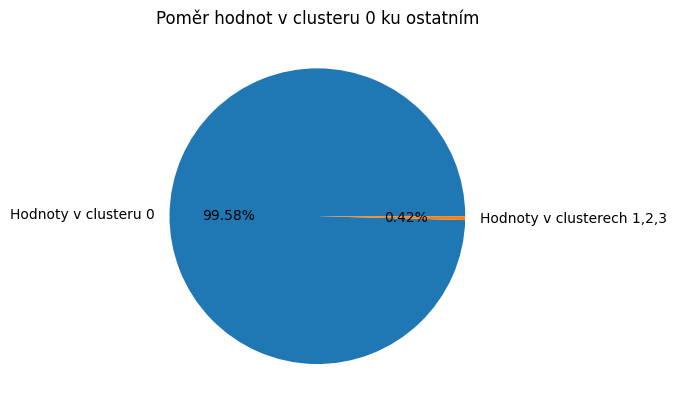

In [11]:
# Navrat puvodnich TLS_SNI hodnot pro dataset 0
df = datasets_save[2]
df["TLS_SNI"] = shorter_tls_labels[2]

print(df["CLUSTER"].value_counts())

n_of_zero_cl = df["CLUSTER"].value_counts().nlargest(1).sum()
rest = df["CLUSTER"].value_counts().sum() - n_of_zero_cl

fig, ax = plt.subplots()
ax.pie([n_of_zero_cl, rest], labels=["Hodnoty v clusteru 0", "Hodnoty v clusterech 1,2,3"], autopct='%1.2f%%');
ax.set_title("Poměr hodnot v clusteru 0 ku ostatním");

- 99.58% všech hodnot patří do jediného clusteru, což je ještě horší než v případě K-Means.
- Davies-Bouldin index ovšem vychází nižší, tedy lepší.
- Výsledek však stále není uspokojivý.

In [12]:
cluster_counts_tls = df.groupby("CLUSTER")["TLS_SNI"].value_counts()
cluster_counts_tls.groupby("CLUSTER").nlargest(10)

CLUSTER  CLUSTER  TLS_SNI                              
0        0        www.google.com                           753
                  dns.google                               310
                  fonts.gstatic.com                        283
                  doh.opendns.com                          278
                  play.googleapis.com                      254
                  www.youtube.com                          240
                  googleads.g.doubleclick.net              235
                  safebrowsing.googleapis.com              229
                  play.google.com                          210
                  mail.google.com                          207
1        1        rr2---sn-2gb7sn7y.googlevideo.com          2
                  www.tanap.sk                               1
                  streetviewpixels-pa.googleapis.com         1
                  3652634706.tapecontent.net                 1
                  cz-bks400-prod11-live.solocoo.tv           1

- V clusteru 2 a 1 se opět často vyskytují služby související se streamingem videa.
- Jelikož stejné výsledky našel i K-Means, může se opravdu jednat o případ, že spojení je rozděleno na více toků.
- Výsledky jsou však stále příliš jednotvárné

## Odpovědi na otázky ze zadání
Veškeré informace vychází z dat popsaných tady v notebooku a z části i při experimentech, které zde nejsou uvedeny pro svou nezajímavost. Celkově byla shluková analýza bohužel neúspěšná, neboť se nepodařilo data rozdělit na dostatečně velké shluky -- většina dat vždy zůstává jen v jednom shluku. Je možné, že jsou si natolik podobné, že to jinak nešlo, ovšem v kontextu zadání se to zdá být nepravděpodobné a problém bude někde jinde. 

### a) Toky s kterými TLS SNI byly shlukovány společně?
Výsledky shlukování byly poněkud neuspokojivé, avšak oba algoritmy odhalily clustery, které obsahují velké množství dat týkající se pravděpodobně přenosu videa (solocoo.tv, youtube.com. googlevideo.com...).

### b) Byli jste schopni nalézt shluky odpovídající přenosu videa, souborů, metadat?
Tato informace bohužel z dat dostupná není. Na základě výsledků shlukování je možno konstatovat, že se pravděpodobně toky ke konkrétním serverům děli na více typů (metadata, videa...), ovšem přesné rozdělení nebylo nalezeno.

### b) Podle kterých statistických informací se toky dobře shlukují?Toky se shlukují primárně podle numerických hodnot, konkrétně pak množství přenesených paketů, bytů a v některých datasetech i čas přenosu nebo TCP vlajky. Experimentálně se ukázalo, že všechny atributy, které jsou v datasetu přítomné, jsou schopny po jejich odstranění výsledky shlukování poměrně silně ovlivnit.

### b) Jaké jsou podskupiny toků, které by bylo možné rozlišit?
Podařilo se rozlišit toky spadající pod služby nabízející streamování videa. Ovšem jen ve velmi omezené míře.

